In [15]:
import numpy as np
from PIL import Image
import subprocess
import torch
from torch import nn
import torch.nn.functional as nf
import torchvision.transforms as transforms
from torchvision.models.resnet import resnet18
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import glob
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import csv
from sklearn.manifold import TSNE

In [16]:
Path_All = './model1_83/'
train_path = Path_All + '/train/'
test_path = Path_All + 'test/'
test_txt_path = Path_All + 'test.txt'
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_all = {}
test_all = {}
for trainable in [True,False]:
    if trainable:
        for category in ['pic1','pic2','pic3','pic4','pic5']:
            train_all[category] = glob.glob(os.path.join(train_path + category,'*.jpg'))   #这种写法是分了两个文件夹
            # print(os.path.join(train_path + category,'*.jpg'))
    else:
        for category in ['pic1','pic2','pic3','pic4','pic5']:
            test_all[category] = glob.glob(os.path.join(test_path + category,'*.jpg'))

In [17]:
class MyDataset(Dataset):
    def __init__(self,txt_path,transform = None , target_transform = None):
        fh = open(txt_path,'r')
        imgs = []
        for line in fh:
            line = line.rstrip()#删除字符串末尾的指定字符，默认为空格
            words = line.split()#分割字符串，默认以空格为分隔符进行全分割
            img_path = words[0]
            img_path = img_path.replace('\\','/') # linux中路径“\\”无法工作
            img_label = int(words[1])
            # print(words[0],'\n',words[1],type(words))
            imgs.append((img_path,img_label))

        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self,index):
        fn, label = self.imgs[index]
        img = Image.open(fn).convert('RGB')
        #convert将图像转化为对应的像素值，有三种模式1、RGB，三通道。2、1,01模式，3、L模式，将每个像素点转化为0-255，单通道
        if self.transform is not None:
            img = self.transform(img)

        return img, label
    def __len__(self):
        return len(self.imgs)

In [18]:
train_paths = train_all['pic1'] + train_all['pic2'] + train_all['pic3'] + train_all['pic4'] + train_all['pic5']
m_list, s_list = [],[]
print('Read pic: \n')
for path in tqdm(train_paths):  #tqdm进度条模式，挺有意思的
    img = cv2.imread(path)
    img = img / 255.0
    m,s = cv2.meanStdDev(img)
    m_list.append(m.reshape((3,)))
    s_list.append(s.reshape((3,)))
m_array = np.array(m_list)
s_array = np.array(s_list)
#转换为矩阵
m = m_array.mean(axis = 0, keepdims = True)
s = s_array.mean(axis = 0, keepdims = True)

# print(m[0][::-1])
# print(s[0][::-1])
###数据预处理，编写transform 进行数据增强
normMean = m[0][::-1].copy()
normStd = s[0][::-1].copy()

normTransform = transforms.Normalize(normMean,normStd)
testTransform = transforms.Compose([
    #transforms.Resize((280,280)),
    # transforms.CenterCrop((1900,990)),
    # transforms.Resize((40,30)),
    transforms.ToTensor(),
    normTransform,
])

test_data = MyDataset(txt_path=test_txt_path,transform = testTransform)
test_loader = DataLoader(dataset = test_data,batch_size = batch_size)

Read pic: 



100%|██████████| 300/300 [00:00<00:00, 4986.45it/s]


In [19]:
new_model = resnet18(pretrained=True).to(device)

class fc_part(nn.Module):
        # fc 全连接层
        def __init__(self):
            super().__init__()
            # self.fc1 = nn.Linear(512,512)
            self.fc1 = nn.Linear(512, 256)
            self.fc2 = nn.Linear(256, 120)
            self.fc3 = nn.Linear(120,5)

        def forward(self, x):
            x = nf.relu(self.fc1(x))
            x = nf.relu(self.fc2(x))
            x = nf.relu(self.fc3(x))
            # x = self.fc1(x)
            return x
new_model.fc = fc_part().to(device)
new_model.load_state_dict(torch.load(Path_All+'best_resnet18_model.pth'))
print(new_model)

/home/lasso/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lasso/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
def plot_cm(labels,pre):
    conf_numpy = confusion_matrix(labels,pre)
    # print(conf_numpy,type(conf_numpy))
    conf_numpy = conf_numpy.astype('float') / conf_numpy.sum(axis = 1)
    conf_numpy_norm = np.around(conf_numpy,decimals=2)
    # conf_df = pd.DataFrame(conf_numpy)#将data和all_label_names制成DataFrame

    plt.figure(1,figsize=(8,7))
    # sns.heatmap(conf_numpy_norm,annot=True,fmt="d",cmap="BuPu")#将data绘制为混淆矩阵
    sns.heatmap(conf_numpy_norm,annot=True,cmap="Blues")#将data绘制为混淆矩阵
    plt.title('confusion matrix',fontsize = 15)
    plt.ylabel('True labels',fontsize = 14)
    plt.xlabel('Predict labels',fontsize = 14)
    plt.tight_layout()
    # plt.savefig(Path_All + 'Output/Test_ConfMatrix.png')
    # plt.savefig(Path_All + 'Output/Test_ConfMatrix.eps',format='eps')

import itertools
def plot_confusion_matrix(labels, pre, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues,fontsize=20):
    plt.figure(figsize=(8, 7))
    conf_numpy = confusion_matrix(labels, pre)
    if normalize:
        conf_numpy = conf_numpy.astype('float') / conf_numpy.sum(axis = 1)
        conf_numpy = np.around(conf_numpy,decimals=3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(conf_numpy)

    plt.figure(1, figsize=(8, 7))
    plt.imshow(conf_numpy, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=fontsize)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=fontsize)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    fmt = '.3f' if normalize else 'd'
    thresh = conf_numpy.max() / 2.
    for i, j in itertools.product(range(conf_numpy.shape[0]), range(conf_numpy.shape[1])):
        plt.text(j, i, format(conf_numpy[i, j], fmt),
                 horizontalalignment="center",
                 fontsize=fontsize,
                 color="white" if conf_numpy[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.tight_layout()
    # plt.savefig(Path_All + 'Output/Test_ConfMatrix.png')
    # plt.savefig(Path_All + 'Output/Test_ConfMatrix.eps', format='eps')

def plot_tsne(tsne_result, labels, classes, legend=True):
    plt.figure(figsize=(8, 7))
    unique_labels = np.unique(labels)
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')

    if legend:
        class_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
        handles = [plt.Line2D([0], [0], marker='o', linestyle='None', color=class_colors[i], markerfacecolor=class_colors[i], markersize=10, label=classes[i]) for i in unique_labels]
        plt.legend(handles=handles, title='Classes')

    plt.title('t-SNE Visualization')
    plt.show()

In [21]:
# for resnet only
def feature_extractor_resnet(model,inputs):
    conv_features = None
    for name, layer in model.named_children():
        # print(name)
        if name == 'fc':  # Stop before the classifier
            break
        inputs = layer(inputs)
        if name == 'avgpool':  # Save the output of the last convolutional layer
            conv_features = inputs   
    features = conv_features.view(conv_features.size(0),-1)
    return features

# for resnet18 only
def feature_extractor_resnet18(model:resnet18,inputs):
    inputs = model.conv1(inputs)
    inputs = model.bn1(inputs)
    inputs = model.relu(inputs)
    inputs = model.maxpool(inputs)
    inputs = model.layer1(inputs)
    inputs = model.layer2(inputs)
    inputs = model.layer3(inputs)
    inputs = model.layer4(inputs)
    inputs = model.avgpool(inputs)
    features = inputs.view(inputs.size(0),-1)
    return features

# for resnet only
def classifier(model,features):
    outputs = model.fc(features)
    _,predicted = torch.max(outputs,axis = 1)
    return predicted

def predict_gesture(model,test_loader,device):
    predicted_list,labels_list = [],[]
    test_loss = 0.0
    test_correct = 0.0
    test_total = 0.0
    all_features = []
    with torch.no_grad():
        model.eval()
        with tqdm(test_loader,desc = 'Test') as t:
            for data in t :
                inputs ,labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                features = feature_extractor_resnet18(model,inputs)
                all_features.append(features.cpu().numpy())
                outputs = model.forward(inputs)
                outputs2 = model.fc(features)
                print(torch.equal(outputs,outputs2))
                l = nf.cross_entropy(outputs,labels)
                test_loss += l.item()
                _,predicted = torch.max(outputs,axis = 1)
                predicted_list.append(predicted)
                labels_list.append(labels)
                test_total += labels.size(0)
                test_correct += torch.sum(predicted == labels).item()
                # print(labels,'\n',predicted)
    test_acc = test_correct/test_total
    print("Accuracy: {}".format(test_acc))
    # # 打开一个.csv文件进行写入
    # with open(Path_All + 'Output/test_acc_alone.csv', 'w', newline='') as csvfile:
    #     writer = csv.writer(csvfile)
    # # 逐行写入数据
    #     row = [1, test_acc]
    #     writer.writerow(row)
    predicted_list=[aa.tolist() for aa in predicted_list]
    # print(predicted_list,type(predicted_list))
    pred_list_total = [i for item in predicted_list for i in item]
    labels_list=[aa.tolist() for aa in labels_list]
    # labels_list = torch.tensor(labels_list)
    labels_list_total = [i for item in labels_list for i in item]
    # plot_cm(labels_list_total,pred_list_total)

    # plot_confusion_matrix(labels=labels_list_total,pre=pred_list_total,classes=['Pushing & Pulling','Beckoning','Rubbing Fingers'],normalize=True)
    # plt.show()
    # plt.figure(2)
    all_features = np.concatenate(all_features, axis=0)
    # print(all_features.shape)
    # tsne = TSNE(n_components=2, init='pca', random_state=RANDOM_STATE_TSNE)
    # tsne_result = tsne.fit_transform(all_features)
    # plot_tsne(tsne_result, labels_list_total, classes=['Pushing & Pulling','Beckoning','Rubbing Fingers'], legend=True)

    return labels_list_total, pred_list_total, all_features

In [22]:
%config InlineBackend.figure_format = 'svg'

## TSNE for test set

Test: 100%|██████████| 13/13 [00:00<00:00, 63.85it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
Accuracy: 0.83
Normalized confusion matrix
[[0.95  0.025 0.    0.    0.025]
 [0.225 0.7   0.05  0.    0.025]
 [0.05  0.05  0.9   0.    0.   ]
 [0.075 0.125 0.025 0.75  0.025]
 [0.    0.125 0.025 0.    0.85 ]]


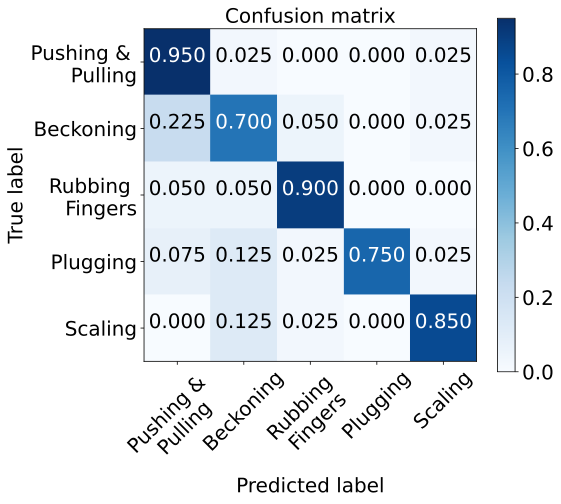

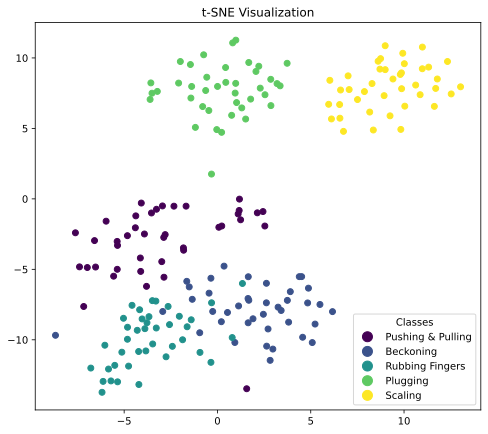

In [23]:
labels_list_total_test, pred_list_total_test, all_features_test = predict_gesture(new_model,test_loader,device)
plot_confusion_matrix(labels=labels_list_total_test,pre=pred_list_total_test,classes=['Pushing & \nPulling','Beckoning','Rubbing \nFingers',"Plugging","Scaling"],normalize=True)
tsne = TSNE(n_components=2, init='pca',random_state=0)
tsne_result_test = tsne.fit_transform(all_features_test)
plot_tsne(tsne_result_test, labels_list_total_test, classes=['Pushing & Pulling','Beckoning','Rubbing Fingers',"Plugging","Scaling"], legend=True)

In [24]:
import json
data = {
    "classes":['Pushing & Pulling','Beckoning','Rubbing Fingers'],
    "labels": labels_list_total_test,
    "pre": pred_list_total_test,
    "features": all_features_test.tolist(),
    "tsne_result": tsne_result_test.tolist()
}

file_path = "tsne.json"

with open(file_path, 'w') as json_file:
    json.dump(data, json_file)

print(f"数据已保存到文件: {file_path}")

数据已保存到文件: tsne.json


## TSNE for whole simulated dataset and real dataset

In [25]:
sim_path = './simulated_data/'
real_path = './real_data/'
sim_txt_path = './simulated_data/sim.txt'
real_txt_path= './real_data/real.txt'
sim_all = {}
real_all = {}
for is_sim in [True,False]:
    if is_sim:
        for category in ['pic1','pic2','pic3','pic4','pic5']:
            sim_all[category] = glob.glob(os.path.join(sim_path + category,'*.jpg'))
            # print(os.path.join(sim_path + category,'*.jpg'))
    else:
        for category in ['pic1','pic2','pic3','pic4','pic5']:
            real_all[category] = glob.glob(os.path.join(real_path + category,'*.jpg'))
mapkey = {
    'pic1' : '0',
    'pic2' : '1',
    'pic3' : '2',
    'pic4' : '3',
    'pic5' : '4',
}
def gen_txt(txt_path, img_paths):
    f = open(txt_path,'w')
    for key in img_paths.keys():
        label = mapkey[key]
        for path in img_paths[key]:
            line = path + ' ' + label +'\n'
            f.write(line)
gen_txt(sim_txt_path,sim_all)
gen_txt(real_txt_path,real_all)
sim_data = MyDataset(txt_path=sim_txt_path,transform = testTransform)
sim_loader = DataLoader(dataset = sim_data,batch_size = batch_size)
real_data = MyDataset(txt_path=real_txt_path,transform = testTransform)
real_loader = DataLoader(dataset = real_data,batch_size = batch_size)

labels_list_total_sim, pred_list_total_sim, all_features_sim = predict_gesture(new_model,sim_loader,device)
labels_list_total_real, pred_list_total_real, all_features_real = predict_gesture(new_model,real_loader,device)

Test:  22%|██▏       | 7/32 [00:00<00:00, 65.23it/s]

True
True
True
True
True
True
True
True
True
True
True


Test:  44%|████▍     | 14/32 [00:00<00:00, 65.05it/s]

True
True
True


Test:  66%|██████▌   | 21/32 [00:00<00:00, 65.24it/s]

True
True
True
True
True
True
True
True
True
True
True


Test:  88%|████████▊ | 28/32 [00:00<00:00, 65.24it/s]

True
True
True


Test: 100%|██████████| 32/32 [00:00<00:00, 65.88it/s]


True
True
True
True
Accuracy: 0.996


Test:  22%|██▏       | 7/32 [00:00<00:00, 65.53it/s]

True
True
True
True
True
True
True
True
True
True


Test:  44%|████▍     | 14/32 [00:00<00:00, 65.67it/s]

True
True
True
True


Test:  66%|██████▌   | 21/32 [00:00<00:00, 65.91it/s]

True
True
True
True
True
True
True
True
True
True


Test:  88%|████████▊ | 28/32 [00:00<00:00, 65.87it/s]

True
True
True
True


Test: 100%|██████████| 32/32 [00:00<00:00, 66.50it/s]

True
True
True
True
Accuracy: 0.828


Normalized confusion matrix
[[0.99 0.   0.01 0.   0.  ]
 [0.   0.99 0.01 0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.  ]]


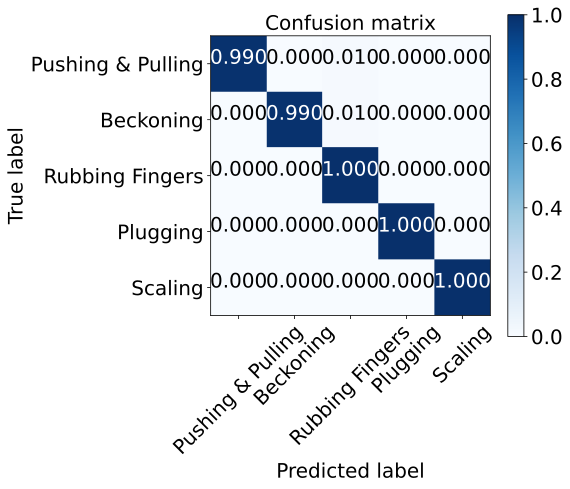

In [26]:
plot_confusion_matrix(labels=labels_list_total_sim,pre=pred_list_total_sim,classes=['Pushing & Pulling','Beckoning','Rubbing Fingers','Plugging','Scaling'],normalize=True)

Normalized confusion matrix
[[0.9  0.02 0.01 0.05 0.02]
 [0.19 0.74 0.06 0.   0.01]
 [0.05 0.07 0.88 0.   0.  ]
 [0.06 0.16 0.01 0.74 0.03]
 [0.   0.11 0.01 0.   0.88]]


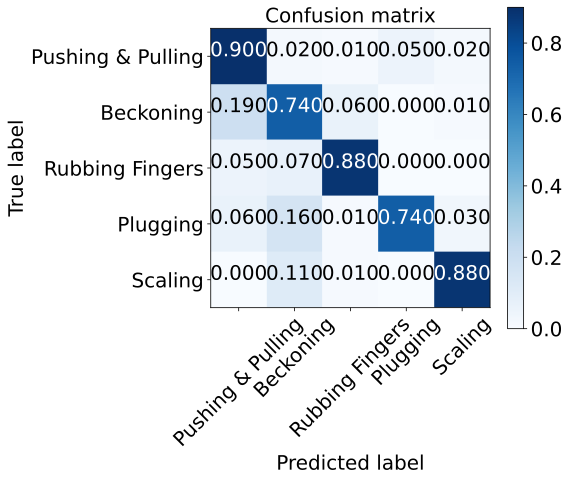

In [27]:
plot_confusion_matrix(labels=labels_list_total_real,pre=pred_list_total_real,classes=['Pushing & Pulling','Beckoning','Rubbing Fingers','Plugging','Scaling'],normalize=True)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


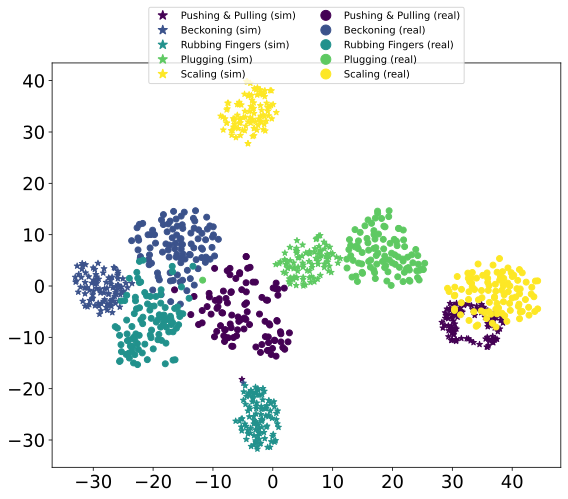

In [28]:

# def plot_tsne_v2(tsne_result_sim, labels_sim, tsne_result_real, labels_real, classes, legend=True):
#     plt.figure(figsize=(8, 7))
#     unique_labels = np.unique(labels_sim+labels_real)
#     print(unique_labels)
#     plt.scatter(tsne_result_sim[:, 0], tsne_result_sim[:, 1], c=labels_sim, cmap='viridis',marker='*')
#     plt.scatter(tsne_result_real[:, 0], tsne_result_real[:, 1], c=labels_real, cmap='viridis',marker='o')

#     if legend:
#         class_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
#         handles1 = [plt.Line2D([0], [0], marker='*', linestyle='None', color=class_colors[i], markerfacecolor=class_colors[i], markersize=10, label=classes[i]+" (sim)") for i in unique_labels]
#         handels2 = [plt.Line2D([0], [0], marker='o', linestyle='None', color=class_colors[i], markerfacecolor=class_colors[i], markersize=10, label=classes[i]+" (real)") for i in unique_labels]
#         handles=handles1+handels2
#         plt.legend(handles=handles, ncol=2, fontsize=10, loc = 'upper center',bbox_to_anchor=(0.5, 1.15))

#     # plt.title('t-SNE Visualization')
#     plt.show()

def plot_tsne_v2(tsne_result_sim, labels_sim, tsne_result_real, labels_real, classes,  savepath='./temp_tsne', title = 't-SNE Visualization', legend=True,fontsize = 18):
    plt.figure(figsize=(8, 7))
    unique_labels = np.unique(labels_sim+labels_real)
    plt.scatter(tsne_result_sim[:, 0], tsne_result_sim[:, 1], c=labels_sim, cmap='viridis',marker='*')
    plt.scatter(tsne_result_real[:, 0], tsne_result_real[:, 1], c=labels_real, cmap='viridis',marker='o')

    if legend:
        class_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
        handles1 = [plt.Line2D([0], [0], marker='*', linestyle='None', color=class_colors[i], markerfacecolor=class_colors[i], markersize=10, label=classes[i]+" (sim)") for i in unique_labels]
        handels2 = [plt.Line2D([0], [0], marker='o', linestyle='None', color=class_colors[i], markerfacecolor=class_colors[i], markersize=10, label=classes[i]+" (real)") for i in unique_labels]
        handles=handles1+handels2
        # lgd = plt.legend(handles=handles, title='Classes',bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=fontsize)
        lgd = plt.legend(handles=handles, ncol=2, fontsize=10, loc = 'upper center',bbox_to_anchor=(0.5, 1.15))
        lgd.get_title().set_fontsize(fontsize=fontsize)

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    # plt.title(title)
    plt.tight_layout()
    plt.savefig(savepath+'.png')
    plt.savefig(savepath+'.eps')
    plt.show()

RANDOM_STATE_TSNE = 5
tsne = TSNE(n_components=2, init='pca', random_state=RANDOM_STATE_TSNE)
tsne_result_sim = tsne.fit_transform(all_features_sim)
tsne_result_real = tsne.fit_transform(all_features_real)
plot_tsne_v2(tsne_result_sim,labels_list_total_sim,tsne_result_real,labels_list_total_real,classes=['Pushing & Pulling','Beckoning','Rubbing Fingers','Plugging','Scaling'],legend=True,savepath="./model1/Output/TSNE")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


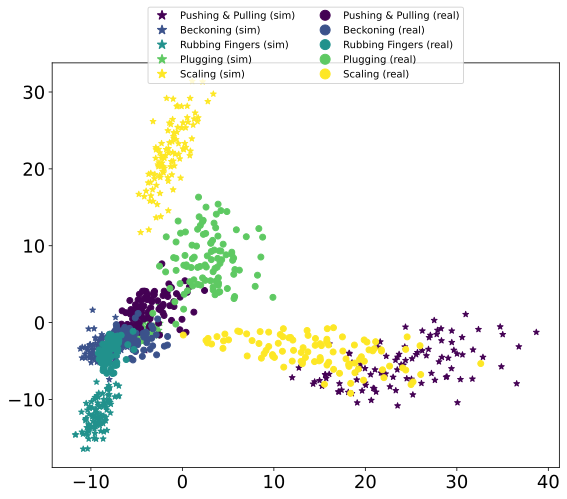

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result_sim = pca.fit_transform(all_features_sim)
pca_result_real = pca.fit_transform(all_features_real)

plot_tsne_v2(pca_result_sim, labels_list_total_sim, pca_result_real, labels_list_total_real, classes=['Pushing & Pulling', 'Beckoning', 'Rubbing Fingers', 'Plugging', 'Scaling'], savepath= './model1//ALL_PCA', legend=True)